In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

# Building Linear Models

So far we have only looked at the simplest linear models that use only one feature--two if the other feature is a binary categorical feature ("binary feature", hereafter):

$\hat{y} = \beta_0 + \beta_1 x_1$

The purpose of the simplification was to get you used to interpreting the coefficients of a linear model. There's nothing that prevents us from adding more features to the equation but as we add more features, the line becomes a *hyperplane* and a lot of intuition goes out the window. It's even difficult to chart these.

The full linear model is:

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_n x_n + N(0, \sigma)$

Here we make a (nuanced) distinction between "feature" and "variable" and the proceed to ignore it because the nomenclature is too entrenched. A "variable" is from the data that you collect via ETL and explore during EDA. A feature is a variable put into a model and may be exactly the same as a variable, transformation, or both. For example, it could be the case that:

$x_2 = mother\_iq$

and

$x_3 = \sqrt{mother\_iq}$

so the variable $mother\_iq$ appears directly and indirectly as *two* features in the model.

This means there may not be a one to one correspondence between variables in your database or other data source and the features in the model. Unfortunately, the term "variable" is so common in discussions that instead of fighting a losing battle, we will use "variable" and "feature" synonymously. Just remember, you often can and should transform your *variables* to create more or better *features*. We will discuss how later in this chapter.

Now that we know that a regression can handle many features, how do we know which ones to add?

## Building Regression Models

The answer is probably not surprising, we should start with domain knowledge. The variables we have available are based on our discussion of the problem, meetings with domain experts, and qualitative modeling with Causal Loop Diagrams. We have wrestled to get the data (ETL) and wrestled with the data (EDA) and at this point we should have some intuitions about the variables, their relationships, and even possible transformations. This is a good starting point.

As a result, our first pass at a model will likely include all the variables we believe are relevant to the target variable, given our knowledge of the domain and the data that we were able to get (rather than the data we *wanted* to get). Whether they were explicit or implicit, we have our Causal Loop Diagrams to guide us. By using domain knowledge, we also satisfy one of the underlying assumptions of correct modeling, the assumption of *validity*. The assumption of validity assumes all the variables have a reason for being in the model.

Although there are techniques for the automatic selection of features, in general, selecting an optimal subset of features is NP-hard. It's easy to see why this is the case. If we have n variables and we want to select k features and build the best model we can, there are n choose k possibilities to pick from:

$\binom{n}{k} = \frac{n!}{k(n-k)!}$

for $n=10$ and $k=9$, that's 10 combinations. But what if the best set is 8? That's 45 more combinations. And if the best set is some 7 of them? 120 *more* combinations. That's a lot of combinations to try. And that doesn't include transformations or interaction terms. Increase the number of variables by 1 and you get even more possibilities.Domain knowledge at least gives us a foot in the door.

We also have the problem that as the sizes of data sets increases, spurious correlations are more likely to result. We don't want to create and field a model that stops working because a relationship we were depending on was ephemeral.

## All Variables? Why One Leg is better than Two

Suppose we have data on human height and measurements for both the left and right leg. Here's a bit of Trivial Pursuit domain knowledge for you:

1. leg length is typically 40-50% of total height which would make leg length a fairly good predictor of height.
2. legs, however, are not always the same length. 70% of people typically have one leg longer than the other. The average difference is generally less than 1.1 cm. Differences of 0-0.30 cm is considered a "mild" difference, 0.31-0.60, is considered moderate and greater than 0.61 is considered severe.

Let's model this system. We just need an average height in centimeters. The average Australian female is 161.8 cm tall. That's about 5' 3" tall. Let's assume that heights are normally distributed with a coefficient of variation of about 10%. That gives us a range of heights. We'll pick an average leg length of 45% with 2.5% points as the standard deviation which will give us 95% of the data between 40-50%. We'll say that's the longer leg.

The shorter leg is generally 1.1 cm shorter than the longer leg and even then 30% of the people don't have noticeably different leg lengths. This is a mixture model: a test to see if a leg length is shorter and then generating a difference. The difference is generally less than 1.1 cm. We can pick uniformly because it doesn't really matter:

In [4]:
np.random.seed(47383484)

In [5]:
data = {}
data["height"] = stats.norm.rvs(161.8, 16.2, 100)
data["long_leg"] = data['height'] * stats.norm.rvs(0.45, 0.025, 100)
data = pd.DataFrame(data)
data["short_leg"] = data["long_leg"].apply(lambda x: x if stats.uniform.rvs() < 0.3 else x - stats.uniform.rvs(0.0, 1.1))

Let's see what we've generated:

In [6]:
data.describe()

,height,long_leg,short_leg
count,100.000000,100.000000,100.000000
mean,160.131744,72.152456,71.759224
std,15.344076,8.446286,8.441024
min,128.082617,55.541141,55.337981
25%,149.066740,65.251453,65.092133
50%,158.561970,71.523243,71.125217
75%,170.632393,77.945643,77.789251
max,202.151122,98.053558,97.670528


So that looks good but we need to get rid of one artifact we created when generating the data. We don't generally collect data as "short" and "long" leg but "left" and "right" leg. Let's shuffle those:

In [7]:
def random_pick(x1, x2):
    return x1 if stats.uniform.rvs() < 0.5 else x2

In [8]:
data["total_leg"] = data["long_leg"] + data["short_leg"]
data["left_leg"] = data[["long_leg", "short_leg"]].apply(lambda x: random_pick(*x), axis=1)
data["right_leg"] = data["total_leg"] - data["left_leg"]

Before we run the code to generate the linear regression model for `height ~ left_leg + right_leg`, what do you expect the coefficients ($\beta_1$ and $\beta_2$) on each leg to be? It seems reasonable to think that they would both be positive:

In [9]:
import sys
sys.path.append('../resources')
import fundamentals.models as models

In [10]:
result = models.bootstrap_linear_regression("height ~ left_leg + right_leg", data)
models.describe_bootstrap_lr(result)

The $R^2$ looks pretty good. Our model captures about 77% of the variability of height. And the coefficients seem to be positive. However, if we look at the credible intervals, there's a strong probability that either or both of the coefficients are negative as well. Based on the data, we don't know what sign the coefficients should be. That seems strange.

This phenomenon goes by the name of *multicolinearity*. So we cannot simply include all of the variables we have even if domain knowledge suggests that they may all be relevant. One way to detect the possibility of such problems is to check for correlations between your features:

In [11]:
stats.pearsonr(data.left_leg, data.right_leg)[0]

0.9979106583969305

You need only check Pearson's Correlation Coefficient because the correlation between the two variables must be linear. Note that checking all pairs of (numerical) variables lands us in the combinatorial explosion again but it's not quite as bad. We can use domain knowledge to prune the pairs we need to check. And we can also check coefficients to see if they have unexpected signs or low credibility for the expected sign.

What should we do?

A general approach is to:

1. include the variable that correlates most highly with the target variable.
2. construct a new variable that combines the information of the other, correlated variables by taking a sum, average, min, max, etc.

Let's try an average leg length:

In [12]:
data["average_leg"] = data["total_leg"] / 2

In [13]:
result = models.bootstrap_linear_regression("height ~ average_leg", data)
models.describe_bootstrap_lr(result)

Now our model is interpretable. Notice that the $R^2$ and $\sigma$ are unaffected. Multicollinearity is very often a concern only if you are building an explanatory model and not simply a predictive one. It's worth remembering the exchange between Blomberg and Gelman from the Introduction:

Simon Blomberg said,

> machine learning is statistics minus any checking of models and assumptions -- Brian D. Ripley [Two Cultures](https://stats.stackexchange.com/questions/6/the-two-cultures- statistics-vs-machine-learning)

To which Bayesian statistician Andrew Gelman responded,

> In that case, maybe we should get rid of checking of models and assumptions more often. Then maybe we'd be able to solve some of the problems that the machine learning people can solve but we can't!

There are a few things that matter greatly to the typical statistician that do not concern a machine learning engineer at all. For example, Andrew Ng teaches linear regression in his online Machine Learning course but he never once mentions multicollinearity. That doesn't mean we can ignore it, too. You have to know what the purpose of your model is. And even if it is only estimation, that doesn't mean somewhere down the road, a regulatory body isn't going to ask you to explain what it does. I present Gelman's advice throughout because I think it's a good middle ground between the two extremes. We concentrate on differences that *make* a difference when the difference is important.

We will now modify our steps for building linear models:

1. Start with all features as suggested by domain knowledge, but...
2. Analyze features for correlations and, of those groups, consider picking the best variable, an average of the variables, or some other transformation (sum, min, max, etc).

Think back to the EDA chapter and the King's County Housing Example. Do you think that sqft_living, sqft_above, sqft_below, sqft_living15 are all correlated? What about sqft_lot and sqft_lot15?

So now we have an extra goal for EDA. If we know that we are going to be building a linear model, we should investigate correlations between variables that we plan to include in our linear model (and not just correlations between the target variables--price in this case--and the features). We add this now because if we're using a different kind of model, the problem of multicollinearity might not even arise.

## Multiple Binary Features

As we have just seen, although linear models are perfectly general, but there can be problems. If there is multicollinearity between two or more features, we will have some difficulty getting good estimates of their coefficients. The values of the coefficients are important if we wish to explain the relationship between the target variable and the features.

Although it's more difficult to introduce multicollinearity between binary features, it's not impossible. Consider the canonical binary feature (that's not entirely binary): gender. Suppose we have $gender$ in the linear model below:

$\hat{y} = \beta_0 + \beta_1 gender + \beta_2 income$

Our first observation is that when it comes to binary variables, we should name them whatever category is "1". So if it's 0 if female and 1 if male, we should just name the variable "male". This helps immeasurably with interpretation:

$\hat{y} = \beta_0 + \beta_1 male + \beta_2 income$

With this model, $\beta_1$ becomes the differential effect being male. Where's the female effect? It's in $\beta_0$.

But why can't we we have a variable, $female$ too and have $\beta_0$ be zero?

$\hat{y} = \beta_0 + \beta_1 male + \beta_2 income + \beta_3 female$

Well, if we think about it a second, this would mean that the data looks like this:

|  | male | female | income |
|---|------|--------|--------|
| 1 | 1 | 0 | 34000 |
| 2 | 0 | 1 | 38000 |
| 3 | 1 | 0 | 42000 |
| 4 | 1 | 0 | 40000 |
| 5 | 0 | 1 | 29000 |

$male$ and $female$ are just the opposite of each other so there's no new information to be gained from including $female$ as a variable. And if male is 1 and female is 0, what is $\beta_0$? This doesn't make sense. All of this seems obvious because we're used to "natural" binary variables like gender, purchased, voted, etc.

What happens if we have a new variable, politics, that has three values: {left, center, right}. Our first thought might be to code these as {1, 2, 3} but that doesn't make sense for linear models: left + center = right? Um, no. Instead we can do a "one hot encoding": left {0, 1}, center: {0, 1}, right: {0, 1}. Now, here's the question. If we want to include these variables in the linear model, 

$\hat{y} = \beta_0 + \beta_1 male + \beta_2 income + \beta_3 left + \beta_4 center + \beta_5 right$

does it look like the above? No and for the same reason that we didn't include both male and female in the model. Here's the rule:

> Every non-binary variable must be converted to a one hot encoding using the label as the feature name if possible. This will create $m$ new binary variables if the original variable has $m$ labels or outcomes. However, you can only include $m-1$ of these new features in your linear model. The missing variable gets pushed into the interpretation of $\beta_0$, the intercept.

Let's see how this works. We're going to take out "left":

$\hat{y} = \beta_0 + \beta_1 male + \beta_2 income + \beta_3 center + \beta_4 right$

We can see that the male effect is $\beta_1$, the center effect is $\beta_3$, and the right effect is $\beta_4$. Where is the female effect? $\beta_0$. Where is the left effect? $\beta_0$. In fact, $\beta_0$ is now "left females".

Where is the effect for right females? $\beta_0 + \beta_4$. Left males? $\beta_0 + \beta_1$.

This makes a strong assumption that politics and gender are independent (no pun intended) and this may not be the case. We may want to create interaction terms. However,

> the more specific the terms in your model, the more data you need to estimate it

If you don't have a lot of Pagan, right, low income males in your data set...you're not going to get good estimates of the coefficients. Binary variables are always partitioning your data set into subpopulations. As we have seen, their presence in a model doesn't have the same effect on the model as a numeric feature.

It follows that of the $m$ one hot encodings, which one do we push into $\beta_0$? It is often said that it doesn't matter but I disagree. You need to take the relative frequency of the subpopulations into account.

Consider what happens if you drop the binary variable with the fewest observations. With fewer observations, $\beta_0$ will have a higher variance than the incremental effect $\beta_1$ (for example). This might not be good if we need a solid estimate of the base effects.

However, if we're interested *only* in the differential effect (how much does it change in the presence of the category), dropping the encoding out of $m$ with the fewest observations might be satisfactory. Conversely, if we *do* want good base rate estimates, then we want to drop the encoding out of $m$ with the most observations. Another option is to combine categories in meaningful ways to increase the number of observations they cover.

No matter what, at least for primary effects, one of the one hot encodings for each such transformed categorical variable needs to be left out. The value will be pushed into the interpretation of $\beta_0$.

We will now modify our steps for building linear models:

1. Start with all features as suggested by domain knowledge, but...
2. Analyze features for correlations and, of those groups, consider picking the best variable, an average of the variables, or some other transformation (sum, min, max, etc).
3. Transform all categorical variables into one hot encodings but leave one encoding out of the model for each variable. The intercept $\beta_0$ represent all the outcomes that are excluded explicitly. Which one you leave out might depend on the number of observations for each and what you want to do with the model.

Most data libraries have functions to create "dummy variables" ("dummy" in the sense of "standing in for something real" as in a "crash test dummy"). Pandas is no exception:

In [14]:
politics = {"politics": np.random.choice(["left", "center", "right"], size=10)}
data = pd.DataFrame(politics)
data.head()

,politics
0,center
1,center
2,center
3,center
4,left


In [15]:
data = pd.concat([data, pd.get_dummies(data["politics"])], axis=1)
data.head()

,politics,center,left,right
0,center,1,0,0
1,center,1,0,0
2,center,1,0,0
3,center,1,0,0
4,left,0,1,0


Now what? We estimate our model. For which we'll go back to Child IQs.

## Child IQs

We've already seen this data but let's quickly review all of it.

In [16]:
child_iq = pd.read_csv( "../resources/data/child_iq.tsv", sep="\t")

In [17]:
child_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
child_iq    434 non-null int64
mom_hs      434 non-null int64
mom_iq      434 non-null float64
mom_work    434 non-null int64
mom_age     434 non-null int64
dtypes: float64(1), int64(4)
memory usage: 17.0 KB


Our target variable is child_iq. Our possible features are mom_hs, mom_iq, mom_work (did the mom work during the preschool years), and the mother's age, mom_age. We can guess that mom_iq and mom_age are numerical but what about the others? Let's see some data:

In [18]:
child_iq.head()

,child_iq,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


Both mom_hs and mom_work seem to encodings of some kind. Let's see how many values they have:

In [19]:
child_iq.mom_hs.value_counts()

1    341
0     93
Name: mom_hs, dtype: int64

As we already knew, mom_hs is a binary variable. What about mom_work?

In [20]:
child_iq.mom_work.value_counts()

4    205
2     96
1     77
3     56
Name: mom_work, dtype: int64

mom_work has four possible values. What are these values? According to the data dictionary:

1. mother did not work for the first 3 years of the child's life.
2. mother worked in second or third year of child's life.
3. mother worked part-time during first year of child's life.
4. mother worked full-time during first year of child's life.

As we can see, the most common outcome is "4".

We'll need to change this variable into a set of dummy variables. Because the labels are numbers, we have two options:

1. change the values into labels in a new variable and then create the dummy variables.
2. specify a prefix for the dummy values.

For this variable, for the first option, we might have "no_work", "some_work", "part_time", and "full_time". For the second option, we can just use "mom_worked" as the prefix and it'll create dummies for "mom_worked_1", "mom_worked_2", "mom_worked_3" and "mom_worked_4". We're going to take the easy way out:

In [21]:
child_iq = pd.concat([child_iq, pd.get_dummies(child_iq["mom_work"], prefix="mom_worked")], axis=1)

In [22]:
child_iq.head()

,child_iq,mom_hs,mom_iq,mom_work,mom_age,mom_worked_1,mom_worked_2,mom_worked_3,mom_worked_4
0,65,1,121.117529,4,27,0,0,0,1
1,98,1,89.361882,4,25,0,0,0,1
2,85,1,115.443165,4,27,0,0,0,1
3,83,1,99.449639,3,25,0,0,1,0
4,115,1,92.745710,4,27,0,0,0,1


We now have mom_iq, mom_age, mom_hs, mom_worked_1 (no work), mom_work_2 (some work), mom_worked_3 (part time), and mom_worked_4 (full time). Before continuing, what do you think the *sign* of each coefficient ($\beta_i$) is going to be?

* `mom_hs`: positive. This could be a proxy for a number of things including income, demographics, intelligence outside general intelligence testing.
* `mom_iq`: positive. It's likely there's a positive relationship between the mother's IQ and the child's.
* `mom_age`: positive. Older mothers might be better educated or more experienced. This could be a proxy for other things including income, demographics, etc.
* `mom_worked_1`: excluded - this the most common outcome for the mom_worked variable so we'll excluded it from explicit inclusion in the model.
* `mom_worked_2`: negative - relative to the baseline, this should show a small decrease in IQ although overall this may be a signifier for demographics and income (if you can afford to take off the first year, you may have good maternity leave or support from the husband's income).
* `mom_worked_3`: negative but more so than mom_worked_2 because it's part-time work throughout the 3 years.
* `mom_worked_4`: negative but more so than mom_worked_3 because it's full-time work throughout the 3 years.

It's interesting to think about the overall implications of the validity assumption here. Depending on the source of the data, this model might not be applicable to minorities, for example. The validity assumption is broader than *just* including relevant variables but also making relevant estimates that are not "out of sample".

Now let's estimate the model: "child_iq ~ mom_hs + mom_iq + mom_age + mom_worked_2 + mom_worked_3 + mom_worked_4"

In [23]:
model = "child_iq ~ mom_hs + mom_iq + mom_age + mom_worked_2 + mom_worked_3 + mom_worked_4"
result = models.bootstrap_linear_regression(model, data=child_iq)
models.describe_bootstrap_lr(result)

## Interpreting the Results

First, we observe that the $R^2$ is 0.22 or 22%. The model explains 22% of the variation in child_iq. However, we note that the Coefficient of Determination is affected by the number of features in your model. That is, other things being equal, as you go from one feature to two to three to four, etc., the $R^2$ will not go down. It may stay the same or increase but it won't go down. That is, $R^2$ is a non-decreasing monotonic function of the number of variables. It is thus prudent to evaluate the *Adjusted* $R^2$ or $\bar{R}^2$ which is:

$\bar{R}^2 = 1 - (1-R^2) \frac{n-1}{n-p-1}$

where $n$ is the number of observations and $p$ is the number of features in the model. We can estimate ours here:

In [24]:
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

In [25]:
adjusted_r_squared(result)

0.2066189806671399

which isn't hugely different. We have 434 observations and 6 features. Once you get into big data territory, the difference will diminish although "big data" is relative. If you have 10,000 observations but 1,000 features, your data isn't really bigger than having 1,000 observations but 10 features.

Second, we note that the error of the regression ($\sigma$) is 18.14 IQ points. What does that error really mean? Answering that question requires us to go on a bit of a tangent.

### Estimating with Linear Regression

The mean value of mom_iq and mom_age are, respectively:

In [26]:
child_iq.mom_iq.mean()

99.99999999999999

In [27]:
child_iq.mom_age.mean()

22.785714285714285

Let's say that's an IQ of 100 (which makes sense!) and an age of 23. If we consider the group of mothers with IQs of 100, who graduated high school, who was 23 years of age, and did not work during the first three years of the child's life we have a feature *vector* of [1, 100.0, 23, 0, 0, 0]. However, given the way the `models` module is set up, we need to include $x_0 = 1$ for the intercept *explicitly* so we have: [**1**, 1, 100.0, 23, 0, 0, 0].


Using that feature vector in the `predict` function of the `LinearRegression` model, we have the following $\hat{child\_iq}$:

In [28]:
predicted = result["model"].predict(np.array([[1, 1, 100.0, 23.0, 0, 0, 0]]))[0][0]
predicted

85.96983127074502

Note: the double array in the function call to `predict` is because predict is set up to take more than one feature vector and return an *array* of predictions.

The predicted *average* IQ of children whose mothers have those characteristics is about 86. And this is where $\sigma$ or the error of the regression comes in. Remember that $\sigma$ is a standard deviation. If these errors are indeed normally distributed, we expect the true value of the child's IQ to be within 1 standard deviation of the prediction 68% of the time; 2 standard deviations, 95% of the time, and 3 standard deviations, 99.7% of the time (the exact figures are 68.27%, 95.45%, and 99.73%...I don't know why we only show the decimal on the last one).

We can do a quick estimate of the 95% bounds on our estimate is:

In [29]:
print("({0:.2f}, {1:.2f})".format(predicted - 2 * result["sigma"], predicted + 2 * result["sigma"]))

(49.69, 122.24)


Is that better than the "null" model or just using the mean child IQ. The mean and standard deviation of child IQ's are:

In [30]:
mean_child_iq = child_iq.child_iq.mean()
std_child_iq = child_iq.child_iq.std()
print("child_iq = {0:.2f} ({1:.2f})".format(mean_child_iq, std_child_iq))

child_iq = 86.80 (20.41)


So for any child, regardless of the characteristics of the mothers, we would predict an IQ of 86.8 and the 95% bounds would be:

In [31]:
print("({0:.2f}, {1:.2f})".format(mean_child_iq - 2 * std_child_iq, mean_child_iq + 2 * std_child_iq))

(45.98, 127.62)


So we've gotten a *little* better?

I know what you're saying...wait...confidence intervals? Well, let's punt on that for now. Given what we now know, it doesn't hurt to do some quick calculations assuming some mathematical distribution (Normal) and giving them a Bayesian interpretation. Let's see what happens if we do it right...

In the result map, we have stored all the Bootstrap estimates for the coefficients and therefore enough information to do bootstrap estimates of the posterior distribution of a prediction. We can write a function for that:

In [32]:
def bootstrap_prediction(result, feature_values):
    # resampled_coefficients is a DataFrame in result.
    # each *row* is a different bootstrap model.
    # we use a Dict instead of Vector because the order may not be preserved.
    # we should modify this to use the model to pick the values and possibly
    # convert interactions terms.
    results = []
    for coefficients in result["resampled_coefficients"].itertuples():
        estimate = 0
        for feature in feature_values.keys():
            estimate += feature_values[feature] * getattr(coefficients, feature)
        results.append(estimate)
    return np.array(results)

The mean of all of our predictions is:

In [33]:
feature_values = {"intercept": 1, "mom_hs": 1, "mom_iq": 100, "mom_age": 23}
posterior_prediction = bootstrap_prediction(result, feature_values)
posterior_prediction.mean()

86.21523981347428

The distribution looks like:

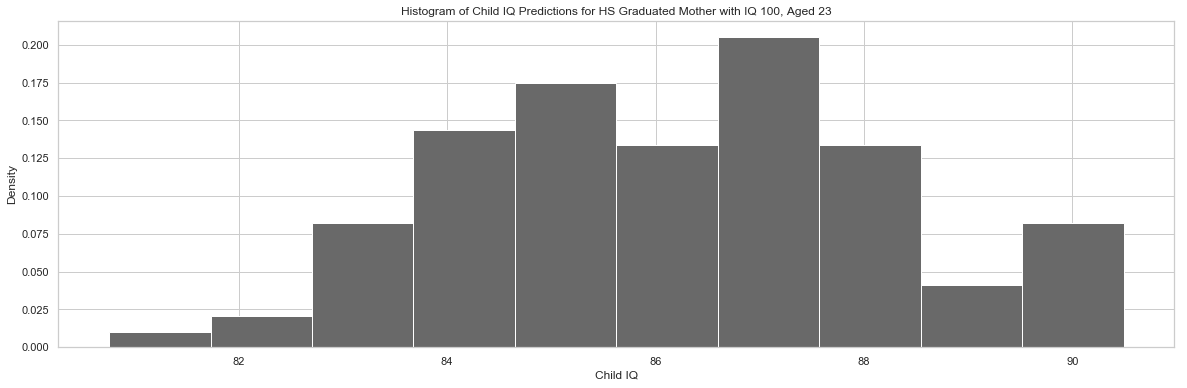

In [34]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(posterior_prediction, color="DimGray", density=True)
axes.set_xlabel( "Child IQ")
axes.set_ylabel( "Density")
axes.set_title("Histogram of Child IQ Predictions for HS Graduated Mother with IQ 100, Aged 23")

plt.show()
plt.close()

Oh, snap. The distribution is grossly normal--that may be an artifact of the number of bootstrap samples we took; we should consider increasing them for the final model. For now, our 95% credible interval (or Bayesian confidence interval) is:

In [35]:
print("95% BCI", stats.mstats.mquantiles( posterior_prediction, [0.025, 0.975]))

95% BCI [82.59661173 90.26274411]


Note that this bound is a lot tighter. Why? Because our feature values are at their means and $\sigma$ is for the *entire* range of each feature. The model will be its most accurate at the mean values of the features.

### Coefficients

Now that we can interpret the $R^2$ and $\sigma$ of the regression, continue with the coefficients which we repeat below:

In [36]:
models.describe_bootstrap_lr(result)

Remember our predictions before we ran the model? Let's write a quick function that compares our predictions based on domain knowledge and the actual values we estimate, in terms of probabilities. Note that this is better than asking if something is "statistically significant".

In [37]:
# {"var1": "+", "var2": "-"}
def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':
            print("{0} P(>0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] > 0)))
        else:
            print("{0} P(<0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] < 0)))

In [38]:
predictions = {
    "mom_hs": '+',
    "mom_iq": '+',
    "mom_age": '+',
    "mom_worked_2": '-',
    "mom_worked_3": '-',
    "mom_worked_4": '-'}
evaluate_coefficient_predictions(predictions, result)

mom_hs P(>0)=0.990
mom_iq P(>0)=1.000
mom_age P(>0)=0.780
mom_worked_2 P(<0)=0.150
mom_worked_3 P(<0)=0.010
mom_worked_4 P(<0)=0.300


From this we see that mom_hs has a very high probability of being positive as does mom_iq. mom_age might be positive; there's a 78% chance, based on the data, that it is. However, for the other three variables that we thought would be negative, there's a very low probability that they are: 15%, 1%, and 30% respectively. What are we to do?

## Guidelines for Evaluating Coefficients

The general guidelines for evaluating coefficients when working with posterior distributions and credible intervals instead of confidence intervals changes a little bit. When we have a confidence interval of (-0.23, 5.97) we note that the coefficient *might* be zero and we just don't know. However, if we have a credible interval with the same bounds and the posterior distribution, we might say there's an 83% probability that the coefficient is positive (or a 17% probability that it's negative).

| Case | Sign | Credible Interval | Action |
|------|------------|--------------------|------------|
| 1    | expected | does not include 0 | Keep  |
| 2    | expected | does include 0 | Keep |
| 3    | unexpected | does not include 0 | Re-examine |
| 4    | unexpected | does include 0 | Remove |

Basically, for this interpretation, we're treating a 95% *credible* interval that contains 0 as some evidence that the coefficient might be (however slim) the oppose sign. Alternatively, we might interpret ranges of the posterior distribution as [0, 33%) "weak" evidence, [33, 66%), "mixed" evidence, and [66%, 100%] "strong" evidence for a particular sign. *Don't get hung up on it*. Use your judgment and experience. If you aren't sure, go with the interval  interpretation until you get experience.

So, why are these rules of thumb the way they are and why they might be reasonable?

In all cases, we can think of "the expected sign" as an informal prior probability of at least the *direction* of influence by the variable, positive or negative. In actual Bayesian modeling it is possible to include this information as an actual prior probability on $\beta_i$ but we're doing this informally here.

**Case 1**

So in the first case, say we have an informal prior of "positive", an actual positive coefficient and the confidence interval that does not include zero. This implies that the confidence interval includes only positive values. Since our informal prior was only about the *sign*, we should keep the variable.

**Case 2**

In the second case, say we have an informal prior of "positive", an actual positive coefficient but the confidence interval includes 0. Remember that the confidence interval is really a section of the posterior probability of the $\beta_i$ in question. If the coefficient is positive and the confidence interval is symmetric, then there must be a greater than 50% probability that the coefficient is positive. This is why we keep it. But since we have the posterior probability, we might be able to find out if the probability really *is* 50/50 and adjust accordingly.

**Case 3**

In the third case, say we have an informal prior of "positive", an actual negative coefficient and a confidence interval that does not include zero. This means that we are pretty confident that, given the data, the probability of the value being negative is 95%. This means that we need to re-evaluate our beliefs about the variables.

For example, if the variable is incumbency. In the US, this is often positively correlated with re-election but in India, incumbency is negatively correlated. The unexpected sign might also mean that some unknown variable is missing. Yes, this can happen, too.

**Case 4**

In the fourth case, say we have an informal prior of "positive", an actual negative coefficient and a confidence interval that includes zero. Because it includes zero and the coefficient is negative, there is a greater than 50% chance the coefficient is actually negative but the evidence is not overwhelming. We could also consider this under the third case if the confidence interval is really skewed towards negative when we expected positive. That is, we can bring in our ideas of "weak", "mixed" and "strong" evidence.

Of course, the reasoning works if we make all the necessary substitutions starting with "say we have an informal prior of 'negative'". We can also think of this in terms of ROPE (region of practical significance), we think of the base line as being zero or not and things "near zero" might be practically zero.

This method of evaluation means thinking ahead of time (remember *validity*?) about the expected sign of the coefficients. This emerges implicitly from our domain knowledge or explicitly through Causal Loop Diagrams.

## Interpreting Coefficients (Again)

There's one last thing we haven't addressed about coefficients.

We already talked about the predictive and the causal interpretations of coefficients. The predictive interpretation is not quite as easy to describe. Basically, linear models are predicting means of some kind. If we look at a set of specific values for a set of features then we're trying to predict the mean of the target variable for that set of feature values. Using child_iq again, if we think of mothers with IQs of 100, then we're predicting the mean IQ of their children. And the $beta_i$ of mom_iq, predicts the change in the mean when we look at mothers with IQs of 101.

The causal interpretation is closer to the "slope" idea of a coefficient. If mother's IQ increases by 1 point, then we expect the child's IQ to change by $\beta_i$, on average. This is also called the *counterfactual* interpretation.

But there's a question that is often asked about linear models that we haven't yet addressed. When you have a model of 10 features, which coefficient, $\beta_i$, is more important? or strongest? And it turns out that this is not an easy question to answer.

The main reason is that the $\beta_i$ coefficients have *two* jobs to do. First, they measure the *effect*. But, second, they *scale* one metric into another. While mom_iq points and child_iq points are in the same units, mom_age and child_iq are not. They are very nearly not even of the same magnitudes and consider a coefficient that must convert from bedrooms to prices in hundreds of thousands of dollars.

Because of this, a large coefficient may be both converting a small number into a larger number's domain and representing a small effect while a smaller coefficient may be converting numbers into the same ranges but represents a (relatively) large effect. It is because of this that it's generally difficult to talk about which coefficients are more important.

We will talk about ways of working around this when we talk about transformations.

But suppose our model isn't very good. Can we make it better? Where should we look? We'll cover that in the remaining sections.